Reproduce performance figures with dumb CV for the appendix

In [1]:
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import copy
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

from tqdm import tqdm
tqdm.pandas()

sys.path.append('../code')
from utils import compute_additional_fields

In [2]:
def aggregate_pickles(all_pickles_paths, dataset_name):
    all_res = []
    
    for fname in all_pickles_paths:
        try:
            res = pickle.load(open(fname,'rb'))
        except (AttributeError, EOFError, TypeError) as e:
            print(e)
            print(fname)
            continue
        res.update(vars(res['args']))
        all_res.append(res)

    df_all = pd.DataFrame(all_res, columns=all_res[0].keys())
    df_all = compute_additional_fields(df_all, dataset_name=dataset_name, dumb_CV=True)
    df_all.drop(columns=['qkern_matrix_train', 'qkern_matrix_test'], inplace=True)
    return df_all

In [3]:
dfs = {}

folders = [
    ("../data/results/IQP", "fashion-mnist"),
    ("../data/results/IQP_kmnist", "kmnist"),
    ("../data/results/IQP_plasticc/", "plasticc"),
    ("../data/results/control_evo_time", "fashion-mnist"),
    ("../data/results/control_evo_time_kmnist/", "kmnist"),
    ("../data/results/control_evo_time_plasticc/", "plasticc"),
]

for folder, dataset_name in folders:
    label = Path(folder).stem
    if "IQP" in folder:
        prefix = "IQP"
    else:
        prefix = "dim"
    all_pickles_paths = list(Path(folder).glob(f"{prefix}*.p"))
    npickles = len(all_pickles_paths)
    # check if the data in the pickles has been aggregated before
    # if not, compute an aggregated pickle with all the extra pickles
    must_reaggregate = True
    path_aggregated = Path(folder, "aggregated_dumb_CV.p")
    if path_aggregated.exists():
        aggregated_df = pickle.load(open(path_aggregated, "rb"))
        if len(aggregated_df) == npickles:
            must_reaggregate = False
            print(f"For {folder}, using aggregated pickle from {path_aggregated}")
            dfs[label] = copy.deepcopy(aggregated_df)
    if must_reaggregate:
        aggregated_df = aggregate_pickles(all_pickles_paths, dataset_name)
        dfs[label] = copy.deepcopy(aggregated_df)
        print(f"For {folder}, saving aggregated pickle in {path_aggregated}")
        pickle.dump(aggregated_df, open(path_aggregated, "wb"))
    dfs[label] = dfs[label][dfs[label]['dataset_dim'] <= 22] 
    if "IQP" in folder:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim']
    else:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim'] + 1

100%|██████████| 373/373 [03:14<00:00,  1.92it/s]


For ../data/results/IQP, saving aggregated pickle in ../data/results/IQP/aggregated_dumb_CV.p


100%|██████████| 133/133 [00:50<00:00,  2.63it/s]


For ../data/results/IQP_kmnist, saving aggregated pickle in ../data/results/IQP_kmnist/aggregated_dumb_CV.p


100%|██████████| 140/140 [01:25<00:00,  1.64it/s]


For ../data/results/IQP_plasticc/, saving aggregated pickle in ../data/results/IQP_plasticc/aggregated_dumb_CV.p


100%|██████████| 735/735 [03:09<00:00,  3.87it/s]


For ../data/results/control_evo_time, saving aggregated pickle in ../data/results/control_evo_time/aggregated_dumb_CV.p


100%|██████████| 729/729 [02:54<00:00,  4.18it/s]


For ../data/results/control_evo_time_kmnist/, saving aggregated pickle in ../data/results/control_evo_time_kmnist/aggregated_dumb_CV.p


100%|██████████| 725/725 [05:33<00:00,  2.17it/s]


For ../data/results/control_evo_time_plasticc/, saving aggregated pickle in ../data/results/control_evo_time_plasticc/aggregated_dumb_CV.p


In [4]:
label2dataset = {Path(x).stem : y for x,y in folders}
label2dataset['IQP'] = 'fmnist'
label2dataset['control_evo_time'] = 'fmnist'

pretty_print_dict = {
    'test_score' : 'Prediction accuracy',
    'train_score' : 'Train accuracy',
    'evo_time' : 'Scaling factor',
    'scaling_factor' : 'Scaling factor',
}

palette = sns.color_palette("viridis",23)
legend_elements = []

def plot_one_score(df, ax, metric_to_plot, x_axis_metric, legend=False):
    """
    Plot one
    """
    dims=list(sorted(set(df['Number of qubits'])))

    for idx2, dim in enumerate(dims):
        to_plot = df[
            (df['Number of qubits'] == dim)
        ]
        x = sorted(set(to_plot[x_axis_metric]))
        x = [ii for ii in x if ii <= 1]
        y = [to_plot[
            to_plot[x_axis_metric] == evo_time
        ][metric_to_plot].mean() for evo_time in x]
        lp = ax.plot(
            x,y,
            label=dim, 
            color=palette[dim-3]
        )
        if legend:
            if (x_axis_metric == 'evo_time' and dim == 23) or (x_axis_metric == 'scaling_factor'):
                legend_elements.append(lp[0])
    ax.set_xscale("log")    
    ax.set_xlabel(pretty_print_dict[x_axis_metric])
    # Shrink current axis's height by 20% on the top
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width, box.height * 0.7])
    

def plot_scores_IQP(dfs, metric_to_plot):
    """
    Plot test score for IQP
    """
    labels = ['IQP', 'IQP_kmnist', 'IQP_plasticc']
    # \textwidth is 6.92654 in
    f, ax = plt.subplots(1, len(labels), figsize=(1.5*6.92654, 2*6.92654/4), sharey=True)
    plt.subplots_adjust(wspace=0.01)
    
    for idx, label in enumerate(labels):
        is_leftmost = idx==0
        is_rightmost = idx==len(labels)-1
        plot_one_score(dfs[label], ax[idx], metric_to_plot, 'scaling_factor', legend = idx==1)
        ax[idx].set_title(r"\texttt{"+label2dataset[label]+r"}")
        if is_leftmost:
            ax[idx].set_ylabel(pretty_print_dict[metric_to_plot])
            ax[idx].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
        else:
            ax[idx].yaxis.set_ticks_position('none')
            
    for one_ax in ax:
        lp_r = one_ax.hlines(y=0.5, xmin=one_ax.get_xlim()[0], xmax=one_ax.get_xlim()[1], 
                 color='k', linestyle='dashed', label='Random guess')
            
    ax[1].legend(
        handles=legend_elements+[lp_r],
        title='Number of qubits',
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.55), 
        ncol=11, 
        labelspacing=0.1,
        columnspacing=1,
    )

            
def plot_scores_HamEvo(dfs, metric_to_plot, n_trotter):
    """
    Plot test score for HamEvo
    """
    labels = ['control_evo_time', 'control_evo_time_kmnist', 'control_evo_time_plasticc']
    # \textwidth is 6.92654 in
    f, ax = plt.subplots(1, len(labels), figsize=(1.5*6.92654, 2*6.92654/4), sharey=True)
    plt.subplots_adjust(wspace=0.01)
    
    for idx, label in enumerate(labels):
        is_leftmost = idx==0
        is_rightmost = idx==len(labels)-1
        df_to_plot = dfs[label]
        plot_one_score(df_to_plot[df_to_plot['n_trotter'] == n_trotter], ax[idx], metric_to_plot, 'evo_time', legend= idx==1)
        ax[idx].set_title(r"\texttt{"+label2dataset[label]+r"}")
        if is_leftmost:
            ax[idx].set_ylabel(pretty_print_dict[metric_to_plot])
            ax[idx].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
        else:
            ax[idx].yaxis.set_ticks_position('none')
            
    for one_ax in ax:
        lp_r = one_ax.hlines(y=0.5, xmin=one_ax.get_xlim()[0], xmax=one_ax.get_xlim()[1], 
                 color='k', linestyle='dashed', label='Random guess')





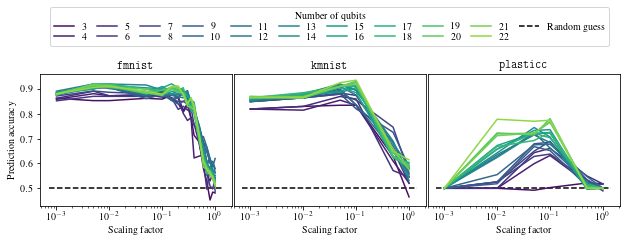

In [5]:
plot_scores_IQP(dfs, 'test_score')
plt.savefig('IQP_test_accuracy_dumb_CV.pdf')

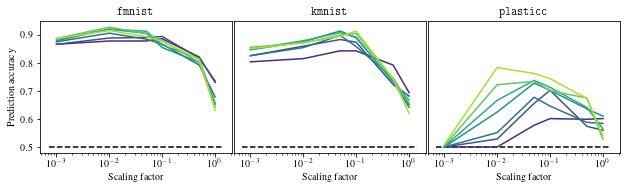

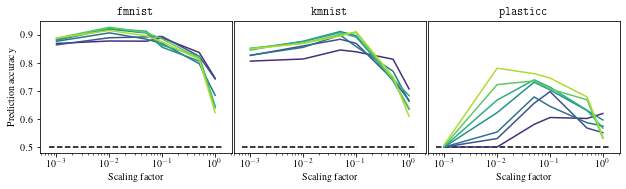

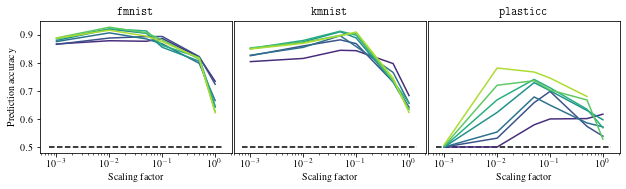

In [6]:
for n_trotter in [10,25,40]:
    plot_scores_HamEvo(dfs, 'test_score', n_trotter)
    plt.savefig(f'HamEvo_test_accuracy_ntrotter_{n_trotter}_dumb_CV.pdf')

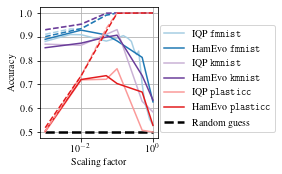

In [7]:
def avoid_green(i):
    if i in [2,3]:
        return i+6
    else:
        return i

metric_to_plot = 'test_score'

f, ax=plt.subplots(figsize=(2*6.92654/2.65, 2*6.92654/5.5))

for idx, label in enumerate(['IQP', 'control_evo_time', 'IQP_kmnist', 'control_evo_time_kmnist', 'IQP_plasticc', 'control_evo_time_plasticc']):
    df_to_plot = dfs[label]
    
    if 'IQP' in label:
        feature_map_name = 'IQP'
        xaxis_name = 'scaling_factor'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19)
        ]
    else:
        feature_map_name = 'HamEvo'
        xaxis_name = 'evo_time'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19) & (df_to_plot['n_trotter'] == 40)
        ]
        
    x = sorted(set(to_plot[xaxis_name]))
    x = [tmp for tmp in x if tmp <= 1]
    y = [to_plot[
        to_plot[xaxis_name] == dim
    ][metric_to_plot].mean() for dim in x]
    ax.plot(
        x,y,
        label=feature_map_name + r" \texttt{" + label2dataset[label] + r"}", 
        color=sns.color_palette("Paired")[avoid_green(idx)]
    )
    

ax.hlines(y=0.5, xmin=0.001, xmax=1, 
                 color='k', linestyle='dashed', label='Random guess', linewidths=2.5)

ax.legend(loc='upper center', 
        bbox_to_anchor=(1.5, 0.9))

metric_to_plot = 'train_score'

for idx, label in enumerate(['IQP', 'control_evo_time', 'IQP_kmnist', 'control_evo_time_kmnist', 'IQP_plasticc', 'control_evo_time_plasticc']):
    df_to_plot = dfs[label]
    
    if 'IQP' in label:
        feature_map_name = 'IQP'
        xaxis_name = 'scaling_factor'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19)
        ]
    else:
        feature_map_name = 'HamEvo'
        xaxis_name = 'evo_time'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19) & (df_to_plot['n_trotter'] == 40)
        ]
        
    x = sorted(set(to_plot[xaxis_name]))
    x = [tmp for tmp in x if tmp <= 1]
    y = [to_plot[
        to_plot[xaxis_name] == dim
    ][metric_to_plot].mean() for dim in x]
    ax.plot(
        x,y,
        label=feature_map_name + r" \texttt{" + label2dataset[label] + r"}", 
        color=sns.color_palette("Paired")[avoid_green(idx)],
        linestyle='dashed'
    )
ax.set_ylabel(r"Accuracy")
ax.set_xlabel(r"Scaling factor")
ax.set_xscale('log')
plt.grid()
plt.tight_layout()
plt.savefig('under_over_fitting_all_dumb_CV.pdf')

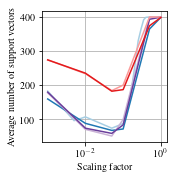

In [8]:
def avoid_green(i):
    if i in [2,3]:
        return i+6
    else:
        return i

metric_to_plot = 'n_support_ave'

f, ax=plt.subplots(figsize=(2*6.92654/5.5, 2*6.92654/5.5))

for idx, label in enumerate(['IQP', 'control_evo_time', 'IQP_kmnist', 'control_evo_time_kmnist', 'IQP_plasticc', 'control_evo_time_plasticc']):
    df_to_plot = dfs[label]
    
    if 'IQP' in label:
        feature_map_name = 'IQP'
        xaxis_name = 'scaling_factor'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19)
        ]
    else:
        feature_map_name = 'HamEvo'
        xaxis_name = 'evo_time'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19) & (df_to_plot['n_trotter'] == 40)
        ]
        
    x = sorted(set(to_plot[xaxis_name]))
    x = [tmp for tmp in x if tmp <= 1]
    y = [to_plot[
        to_plot[xaxis_name] == dim
    ][metric_to_plot].mean() for dim in x]
    ax.plot(
        x,y,
        label=feature_map_name + r" \texttt{" + label2dataset[label] + r"}", 
        color=sns.color_palette("Paired")[avoid_green(idx)]
    )
    
    
# ax.set_ylim(bottom=0.57)
ax.set_ylabel(r"Average number of support vectors")
ax.set_xlabel(r"Scaling factor")
ax.set_xscale('log')
# ax.legend()
plt.grid()
plt.tight_layout()
plt.savefig('nsupport_all_dumb_CV.pdf')

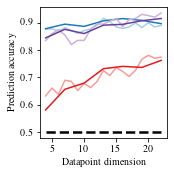

In [9]:
def get_best_params_for_label(label):
    if label == 'IQP':
        return {'scaling_factor' : 0.05}
    elif label == 'IQP_kmnist':
        return {'scaling_factor' : 0.10}
    elif label == 'IQP_plasticc':
        return {'scaling_factor' : 0.10}
    elif label == 'control_evo_time':
        return {'evo_time' : 0.05, 'n_trotter': 40}
    elif label == 'control_evo_time_kmnist':
        return {'evo_time' : 0.10, 'n_trotter': 10}
    elif label == 'control_evo_time_plasticc':
        return {'evo_time' : 0.05, 'n_trotter': 25}
    else:
        raise ValueError(f'Unknown label: {label}')

def avoid_green(i):
    if i in [2,3]:
        return i+6
    else:
        return i

metric_to_plot = 'test_score'

f, ax=plt.subplots(figsize=(2*6.92654/5.5, 2*6.92654/5.5))

for idx, label in enumerate(['IQP', 'control_evo_time', 'IQP_kmnist', 'control_evo_time_kmnist', 'IQP_plasticc', 'control_evo_time_plasticc']):
    df_to_plot = dfs[label]
    
    params = get_best_params_for_label(label)
    
    if 'IQP' in label:
        feature_map_name = 'IQP'
        to_plot = df_to_plot[
            (df_to_plot['scaling_factor'] == params['scaling_factor'])
        ]
    else:
        feature_map_name = 'HamEvo'
        to_plot = df_to_plot[
            (df_to_plot['evo_time'] == params['evo_time']) & (df_to_plot['n_trotter'] == params['n_trotter'])
        ]
        
    x = sorted(set(to_plot['dataset_dim']))
    x = [tmp for tmp in x if tmp >= 4]
    y = [to_plot[
        to_plot['dataset_dim'] == dim
    ][metric_to_plot].mean() for dim in x]
    ax.plot(
        x,y,
        label=feature_map_name + r" \texttt{" + label2dataset[label] + r"}", 
        color=sns.color_palette("Paired")[avoid_green(idx)]
    )


ax.hlines(y=0.5, xmin=4, xmax=22, 
                 color='k', linestyle='dashed', label='Random guess', linewidths=2.5)
ax.set_ylabel(r"Prediction accuracy")
ax.set_xlabel(r"Datapoint dimension")
plt.tight_layout()
plt.savefig('performance_vs_nqubits_all_dumb_CV.pdf')